In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import bout.clustering as clstr
import bout.assembly as bt
import bout.plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import FREQ_GROUPS, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        if 'freq_group' in plot_dets.columns:
            box_color = FREQUENCY_COLOR_MAPPINGS[row['freq_group']]
        else:
            box_color = 'yellow'
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=box_color, facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)
        
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

In [5]:
def assemble_initial_location_summary(file_paths):
    """
    Puts together all bd2 outputs in data/raw and converts detection start_times to datetime objects.
    Returns and saves a summary of bd2-detected bat calls within a desired frequency band.
    """

    location_df = dd.read_csv(f'{file_paths["raw_SITE_folder"]}/*.csv', dtype=str).compute()
    location_df['start_time'] = location_df['start_time'].astype('float64')
    location_df['end_time'] = location_df['end_time'].astype('float64')
    location_df['low_freq'] = location_df['low_freq'].astype('float64')
    location_df['high_freq'] = location_df['high_freq'].astype('float64')
    file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
    anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'], unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'], unit='S')

    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)

    return location_df

def add_frequency_groups_to_summary_using_thresholds(location_df, file_paths, data_params, save=True):
    
    location_df.insert(0, 'freq_group', '')
    groups = FREQ_GROUPS[data_params['site_tag']]
    blue_group = groups['LF1']
    red_group = groups['HF1']
    yellow_group = groups['HF2']

    call_is_yellow = (location_df['low_freq']>=yellow_group[0])&(location_df['high_freq']<=yellow_group[1])
    call_is_red = (location_df['low_freq']>=red_group[0])&(location_df['high_freq']<=red_group[1])
    call_is_blue = (location_df['low_freq']>=blue_group[0])&(location_df['high_freq']<=blue_group[1])

    location_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
    location_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
    location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'

    if data_params['type_tag'] != '':
        location_df = location_df.loc[location_df['freq_group']==data_params['type_tag']]

    if save:
        location_df.to_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv')

    return location_df

In [6]:
def add_frequency_group_to_file_dets(file_dets, location_classes):
    file_classes = location_classes[pd.to_datetime(location_classes['file_name'], 
                                                   format='%Y%m%d_%H%M%S.WAV', exact=False)==file_dets.name].copy()

    file_dets.insert(0, 'index_in_summary', file_dets.index)
    file_dets.set_index('index_in_file', inplace=True)

    classified = file_classes['KMEANS_CLASSES']!=''
    file_classes.loc[classified, 'peak_frequency'] = file_classes.loc[classified, 'peak_frequency'].astype('float64')

    file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
    file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
    file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values

    classified_dets = file_dets['freq_group']!=''
    assert (file_dets.loc[classified_dets, 'peak_frequency'] >= file_dets.loc[classified_dets, 'low_freq']-5000).all()
    assert (file_dets.loc[classified_dets, 'peak_frequency'] <= file_dets.loc[classified_dets, 'high_freq']+5000).all()

    return file_dets

In [7]:
def add_frequency_groups_to_summary_using_kmeans(location_df, file_paths, data_params, save=True):
    location_df.insert(0, 'freq_group', '')
    location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
    location_df.insert(0, 'input_file_dt', pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
    location_df_grouped = location_df.groupby('input_file_dt', group_keys=True)

    location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets(x, location_classes))

    location_df_only_classified = location_df_classified.loc[location_df_classified['freq_group']!='']
    location_df_only_classified = location_df_only_classified.droplevel(level=0)
    location_df_only_classified = location_df_only_classified.reset_index()

    if data_params['type_tag'] != '':
        location_df_only_classified = location_df_only_classified.loc[location_df_only_classified['freq_group']==data_params['type_tag']]

    if save:
        location_df_only_classified.to_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv')

    return location_df_only_classified

In [8]:
def prepare_location_sumary(data_params, pipeline_params, file_paths):
    init_location_sum = assemble_initial_location_summary(file_paths) 
    init_location_sum.reset_index(inplace=True)
    init_location_sum.rename({'index':'index_in_file'}, axis='columns', inplace=True)
    if pipeline_params['use_threshold_to_group']:
        location_sum = add_frequency_groups_to_summary_using_thresholds(init_location_sum.copy(), file_paths, data_params) ## Use to update any bd2__(location summary).csv files
    if pipeline_params['use_kmeans_to_group']:
        location_sum = add_frequency_groups_to_summary_using_kmeans(init_location_sum.copy(), file_paths, data_params)

    return location_sum

In [9]:
site_key = 'Central'
freq_key = 'HF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[9])
file_path

PosixPath('../data/audiomoth_recordings/recover-20220828/Central/20220826_073000.WAV')

In [10]:
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 780
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

In [11]:
init_location_sum = assemble_initial_location_summary(file_paths) 
init_location_sum.reset_index(inplace=True)
init_location_sum.rename({'index':'index_in_file'}, axis='columns', inplace=True)
init_location_df = init_location_sum.copy()
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)

In [12]:
init_location_df.insert(0, 'freq_group', '')
init_location_df.insert(0, 'input_file_dt', pd.to_datetime(init_location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
location_df_grouped = init_location_df.groupby('input_file_dt', group_keys=True)

file_dets = init_location_df[init_location_df['input_file_dt']==dt.datetime(2022,7,27,8,0,0)].copy()
file_classes = location_classes[pd.to_datetime(location_classes['file_name'], 
                                                   format='%Y%m%d_%H%M%S.WAV', exact=False)==dt.datetime(2022,7,27,8,0,0)].copy()

file_dets.insert(0, 'index_in_summary', file_dets.index)
file_dets.set_index('index_in_file', inplace=True)

classified = file_classes['KMEANS_CLASSES']!=''
file_classes.loc[classified, 'peak_frequency'] = file_classes.loc[classified, 'peak_frequency'].astype('float64')

file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values

classified_dets = file_dets['freq_group']!=''
assert (file_dets.loc[classified_dets, 'peak_frequency'] >= file_dets.loc[classified_dets, 'low_freq']-5000).all()
assert (file_dets.loc[classified_dets, 'peak_frequency'] <= file_dets.loc[classified_dets, 'high_freq']+5000).all()

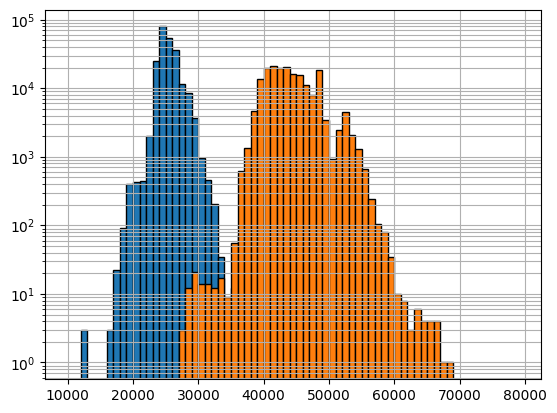

In [13]:
test_LF = location_classes.loc[location_classes['KMEANS_CLASSES']=='LF']
plt.hist(test_LF['peak_frequency'].values, bins=np.arange(1e4, 8e4, 1000), edgecolor='k')
test_HF = location_classes.loc[location_classes['KMEANS_CLASSES']=='HF']
plt.hist(test_HF['peak_frequency'].values, bins=np.arange(1e4, 8e4, 1000), edgecolor='k')
plt.yscale('log')
plt.grid(which='both')

In [14]:
location_df = add_frequency_groups_to_summary_using_kmeans(init_location_sum.copy(), file_paths, data_params)

In [15]:
file_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_end = file_start + dt.timedelta(minutes=30)
plot_dets = location_df.loc[(location_df['call_start_time']>=file_start)&(location_df['call_end_time']<=file_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

In [16]:
plot_dets

,index_in_file,peak_frequency,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,...,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
243137,452,48000.0,244809,2022-08-26 07:30:00,HF,2022-08-26 07:40:14.737500,2022-08-26 07:40:14.737500,2022-08-26 07:40:14.744600,614.7375,614.7446,...,Echolocation,Pipistrellus pipistrellus,0.417,0.521,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN
243138,453,48000.0,244810,2022-08-26 07:30:00,HF,2022-08-26 07:40:14.917500,2022-08-26 07:40:14.917500,2022-08-26 07:40:14.923800,614.9175,614.9238,...,Echolocation,Pipistrellus pipistrellus,0.499,0.538,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN
243139,454,48960.0,244811,2022-08-26 07:30:00,HF,2022-08-26 07:40:15.047500,2022-08-26 07:40:15.047500,2022-08-26 07:40:15.053100,615.0475,615.0531,...,Echolocation,Pipistrellus pipistrellus,0.474,0.533,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN
243140,455,48960.0,244812,2022-08-26 07:30:00,HF,2022-08-26 07:40:15.112500,2022-08-26 07:40:15.112500,2022-08-26 07:40:15.119400,615.1125,615.1194,...,Echolocation,Pipistrellus pipistrellus,0.563,0.587,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN
243141,456,48960.0,244813,2022-08-26 07:30:00,HF,2022-08-26 07:40:15.172500,2022-08-26 07:40:15.172500,2022-08-26 07:40:15.178200,615.1725,615.1782,...,Echolocation,Pipistrellus pipistrellus,0.551,0.612,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243667,982,45120.0,245339,2022-08-26 07:30:00,HF,2022-08-26 07:52:00.379500,2022-08-26 07:52:00.379500,2022-08-26 07:52:00.385700,1320.3795,1320.3857,...,Echolocation,Myotis daubentonii,0.234,0.531,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN
243668,983,44160.0,245340,2022-08-26 07:30:00,HF,2022-08-26 07:52:00.583500,2022-08-26 07:52:00.583500,2022-08-26 07:52:00.589900,1320.5835,1320.5899,...,Echolocation,Myotis daubentonii,0.25,0.513,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN
243669,984,46080.0,245341,2022-08-26 07:30:00,HF,2022-08-26 07:52:00.641500,2022-08-26 07:52:00.641500,2022-08-26 07:52:00.647900,1320.6415,1320.6479,...,Echolocation,Myotis daubentonii,0.248,0.532,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN
243670,985,46080.0,245342,2022-08-26 07:30:00,HF,2022-08-26 07:52:00.848500,2022-08-26 07:52:00.848500,2022-08-26 07:52:00.854200,1320.8485,1320.8542,...,Echolocation,Myotis daubentonii,0.267,0.503,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,Central Pond,recover-20220828,UBNA_010,NaN


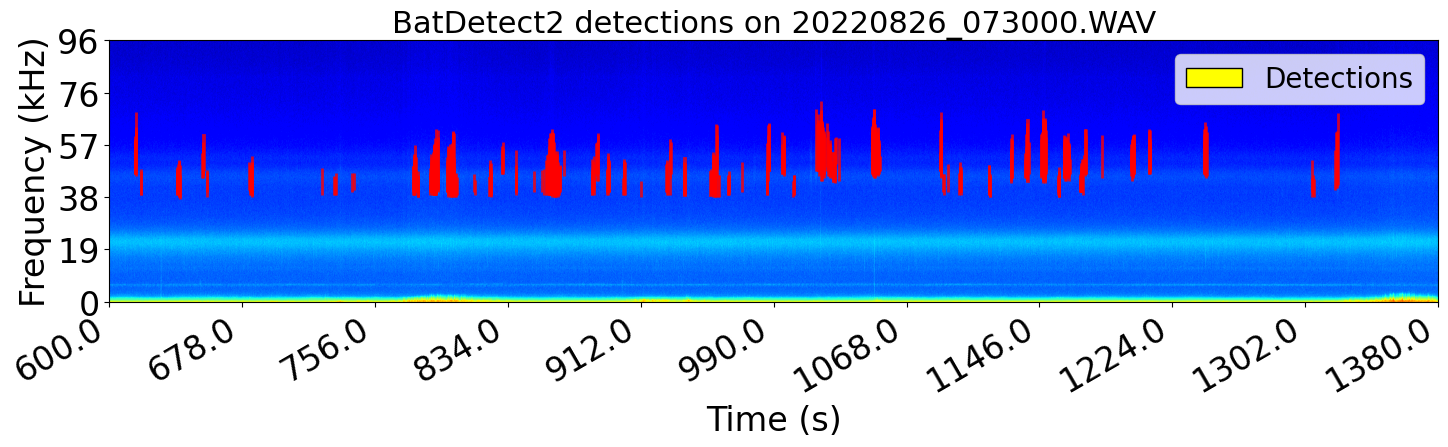

In [17]:
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets)